<a href="https://colab.research.google.com/github/animalecs/facial_keypoints_recognition/blob/master/facial_keypoints_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade tensorflow

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Convolution2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
%matplotlib inline

VERBOSE = False

Using TensorFlow backend.


In [0]:
train_data = pd.read_csv("drive/My Drive/ml_data/facial_keypoints_recognition/training.csv")
test_data = pd.read_csv("drive/My Drive/ml_data/facial_keypoints_recognition/test.csv")

In [0]:
def format_images(text_images, dims, norm=False):
    """
    Receives an image formatted as a string and outputs it as 
    a numpy array of the desired size
    Input:
    text_images: string array of pixel values
    dims: tuple containing the output shape of the image
    norm: boolean, if true the function normalizes the output
    Output:
    images: array of shaped images 
    """
    w, h, c = (dims)
    images = []
    for i in range(0, text_images.shape[0]):
        # Get every image object, cast it to a string and split it 
        # since every value is a pixel
        splitted_img = text_images[i].split(' ')
        images.append(splitted_img)
    # Cast from list to numpy array
    images = np.array(images, dtype="float")
    # Reshape in the final size
    images = images.reshape(-1, w, h, c)
    if norm == True:
        images = images / 255
        
    return images
    

In [0]:
def plot_img(img, keypoints=None):
  """
  Plots a face image with the keypoints associated
  Input:
  img: the image to plot
  keypoints: a numpy array with 30 values (15 coords with x,y)
  """
  # We have to reshape it again because imageplotlib can show images
  # in black/white with just 2 dims or colored images with 3 dims
  plt.imshow(img.reshape(96, 96), cmap="gray")
  if not keypoints is None and keypoints.any() == True:
    for i in range(15):
      # print(train_data.iloc[img_index, i])
      # print(train_data.iloc[img_index, i+1])
      plt.scatter(keypoints[i*2], keypoints[i*2+1], s=5, c='red', marker='o')
  plt.show()

In [0]:
if VERBOSE == True:
  # Check the data type of each column
  print("\r\nData types: ")
  print(train_data.dtypes)
  # Check the data
  print("\r\nFirst data values: ")
  print(train_data.head().T)
  # Check if there are missing values
  print("\r\nMissing values: ")
  print(train_data.isnull().sum())

# Remove the last row since the image doesn't have all the pixels
train_data.head(-1)

# Fill the Nan values with the last valid number of the column
# TO DO - try to drop the row with NaN values
train_data = train_data.fillna(method='ffill')

In [0]:
raw_images = train_data["Image"]
#Drop the images column from the dataset
train_data = train_data.drop('Image',axis = 1)

input_images = format_images(raw_images, (96, 96, 1))

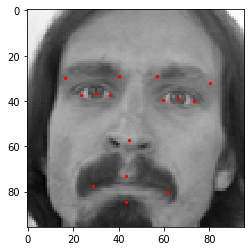

In [7]:
# Plot the first image to check it
img_index = 0
data_row = train_data.iloc[img_index].to_numpy()
temp_img = input_images[img_index]
plot_img(temp_img, data_row)

In [0]:

# Normalize images
input_images = input_images / 255

In [9]:
model = Sequential()
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
# Without dropout the model overfits the small dataset
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128 

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [11]:
history = model.fit(input_images, train_data, epochs = 40,batch_size = 256, validation_split = 0.1, shuffle=True)



Train on 6344 samples, validate on 705 samples
Epoch 1/40
6344/6344 [==============================] - 16s 3ms/step - loss: 242.8118 - mean_absolute_error: 10.0044 - val_loss: 916.9147 - val_mean_absolute_error: 27.1195
Epoch 2/40
6344/6344 [==============================] - 7s 1ms/step - loss: 36.4666 - mean_absolute_error: 4.7304 - val_loss: 591.8913 - val_mean_absolute_error: 22.0583
Epoch 3/40
6344/6344 [==============================] - 7s 1ms/step - loss: 31.4568 - mean_absolute_error: 4.3612 - val_loss: 359.1862 - val_mean_absolute_error: 17.4190
Epoch 4/40
6344/6344 [==============================] - 7s 1ms/step - loss: 26.7165 - mean_absolute_error: 4.0209 - val_loss: 264.8357 - val_mean_absolute_error: 14.9935
Epoch 5/40
6344/6344 [==============================] - 7s 1ms/step - loss: 25.8408 - mean_absolute_error: 3.9362 - val_loss: 346.6133 - val_mean_absolute_error: 16.7119
Epoch 6/40
6344/6344 [==============================] - 7s 1ms/step - loss: 26.5971 - mean_absolut

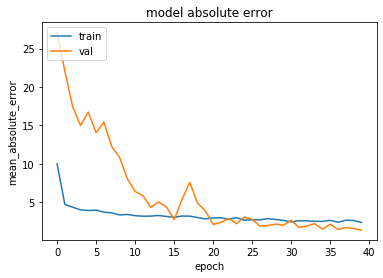

In [12]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model absolute error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
test_data = test_data['Image']
test_data = format_images(test_data, (96, 96, 1))

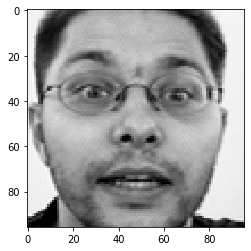

In [24]:
plot_img(test_data[0])

In [0]:
test_data = test_data/255
pred = model.predict(test_data)

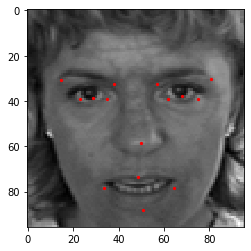

In [25]:
plot_img(test_data[1], pred[1])